In [171]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import time
from math import log10, floor
import os
import glob
import matplotlib.pyplot as plt
import itertools
import datetime
from math import ceil, isnan
from params import *
import sys
import seaborn as sns
try:
    import torchtext
    from torchtext.data import Field, Iterator, Dataset, Example
except ImportError: 
    !{'/opt/anaconda3/bin/python3'} -m pip install --upgrade git+https://github.com/pytorch/text
    import torchtext
    from torchtext.data import Field, Iterator, Dataset, Example
try:
    import catheat
except ImportError: 
    !{'/opt/anaconda3/bin/python3'} -m pip install git+git://github.com/schlegelp/catheat@master
    import catheat

from relational_rnn_models import RelationalMemoryGenerator
from discriminator import RelGANDiscriminator

cuda = torch.cuda.is_available()

# Try setting the device to a GPU
device = torch.device("cuda:0" if cuda else "cpu")
print('Device:', device)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Device: cuda:0


In [13]:
search_results = pd.read_csv('search_results/random_search.csv', index_col = 0)
print(len(search_results))
print(search_results.iloc[search_results['transition_score'].idxmin()])
search_results.head()

20
batch_size           236.000000
chi-squared_score      0.011686
embed_size             5.000000
head_size              5.000000
lr                     4.000000
mem_slots              4.000000
n_embeddings           1.000000
num_blocks             4.000000
num_filters            2.000000
num_heads              4.000000
out_channels           2.000000
temperature           40.000000
transition_score       0.948188
Name: 17, dtype: float64


,batch_size,chi-squared_score,embed_size,head_size,lr,mem_slots,n_embeddings,num_blocks,num_filters,num_heads,out_channels,temperature,transition_score
0,238.0,0.183936,4.0,5.0,4.0,3.0,5.0,3.0,2.0,5.0,4.0,67.0,1.264779
1,94.0,0.025993,5.0,2.0,4.0,5.0,3.0,6.0,2.0,16.0,9.0,26.0,1.190612
2,43.0,1.441178,7.0,7.0,3.0,9.0,7.0,2.0,2.0,7.0,2.0,62.0,2.447488
3,240.0,0.880238,8.0,3.0,3.0,6.0,1.0,4.0,2.0,15.0,6.0,22.0,2.951398
4,159.0,0.049086,6.0,4.0,3.0,8.0,4.0,1.0,1.0,7.0,2.0,19.0,2.127666


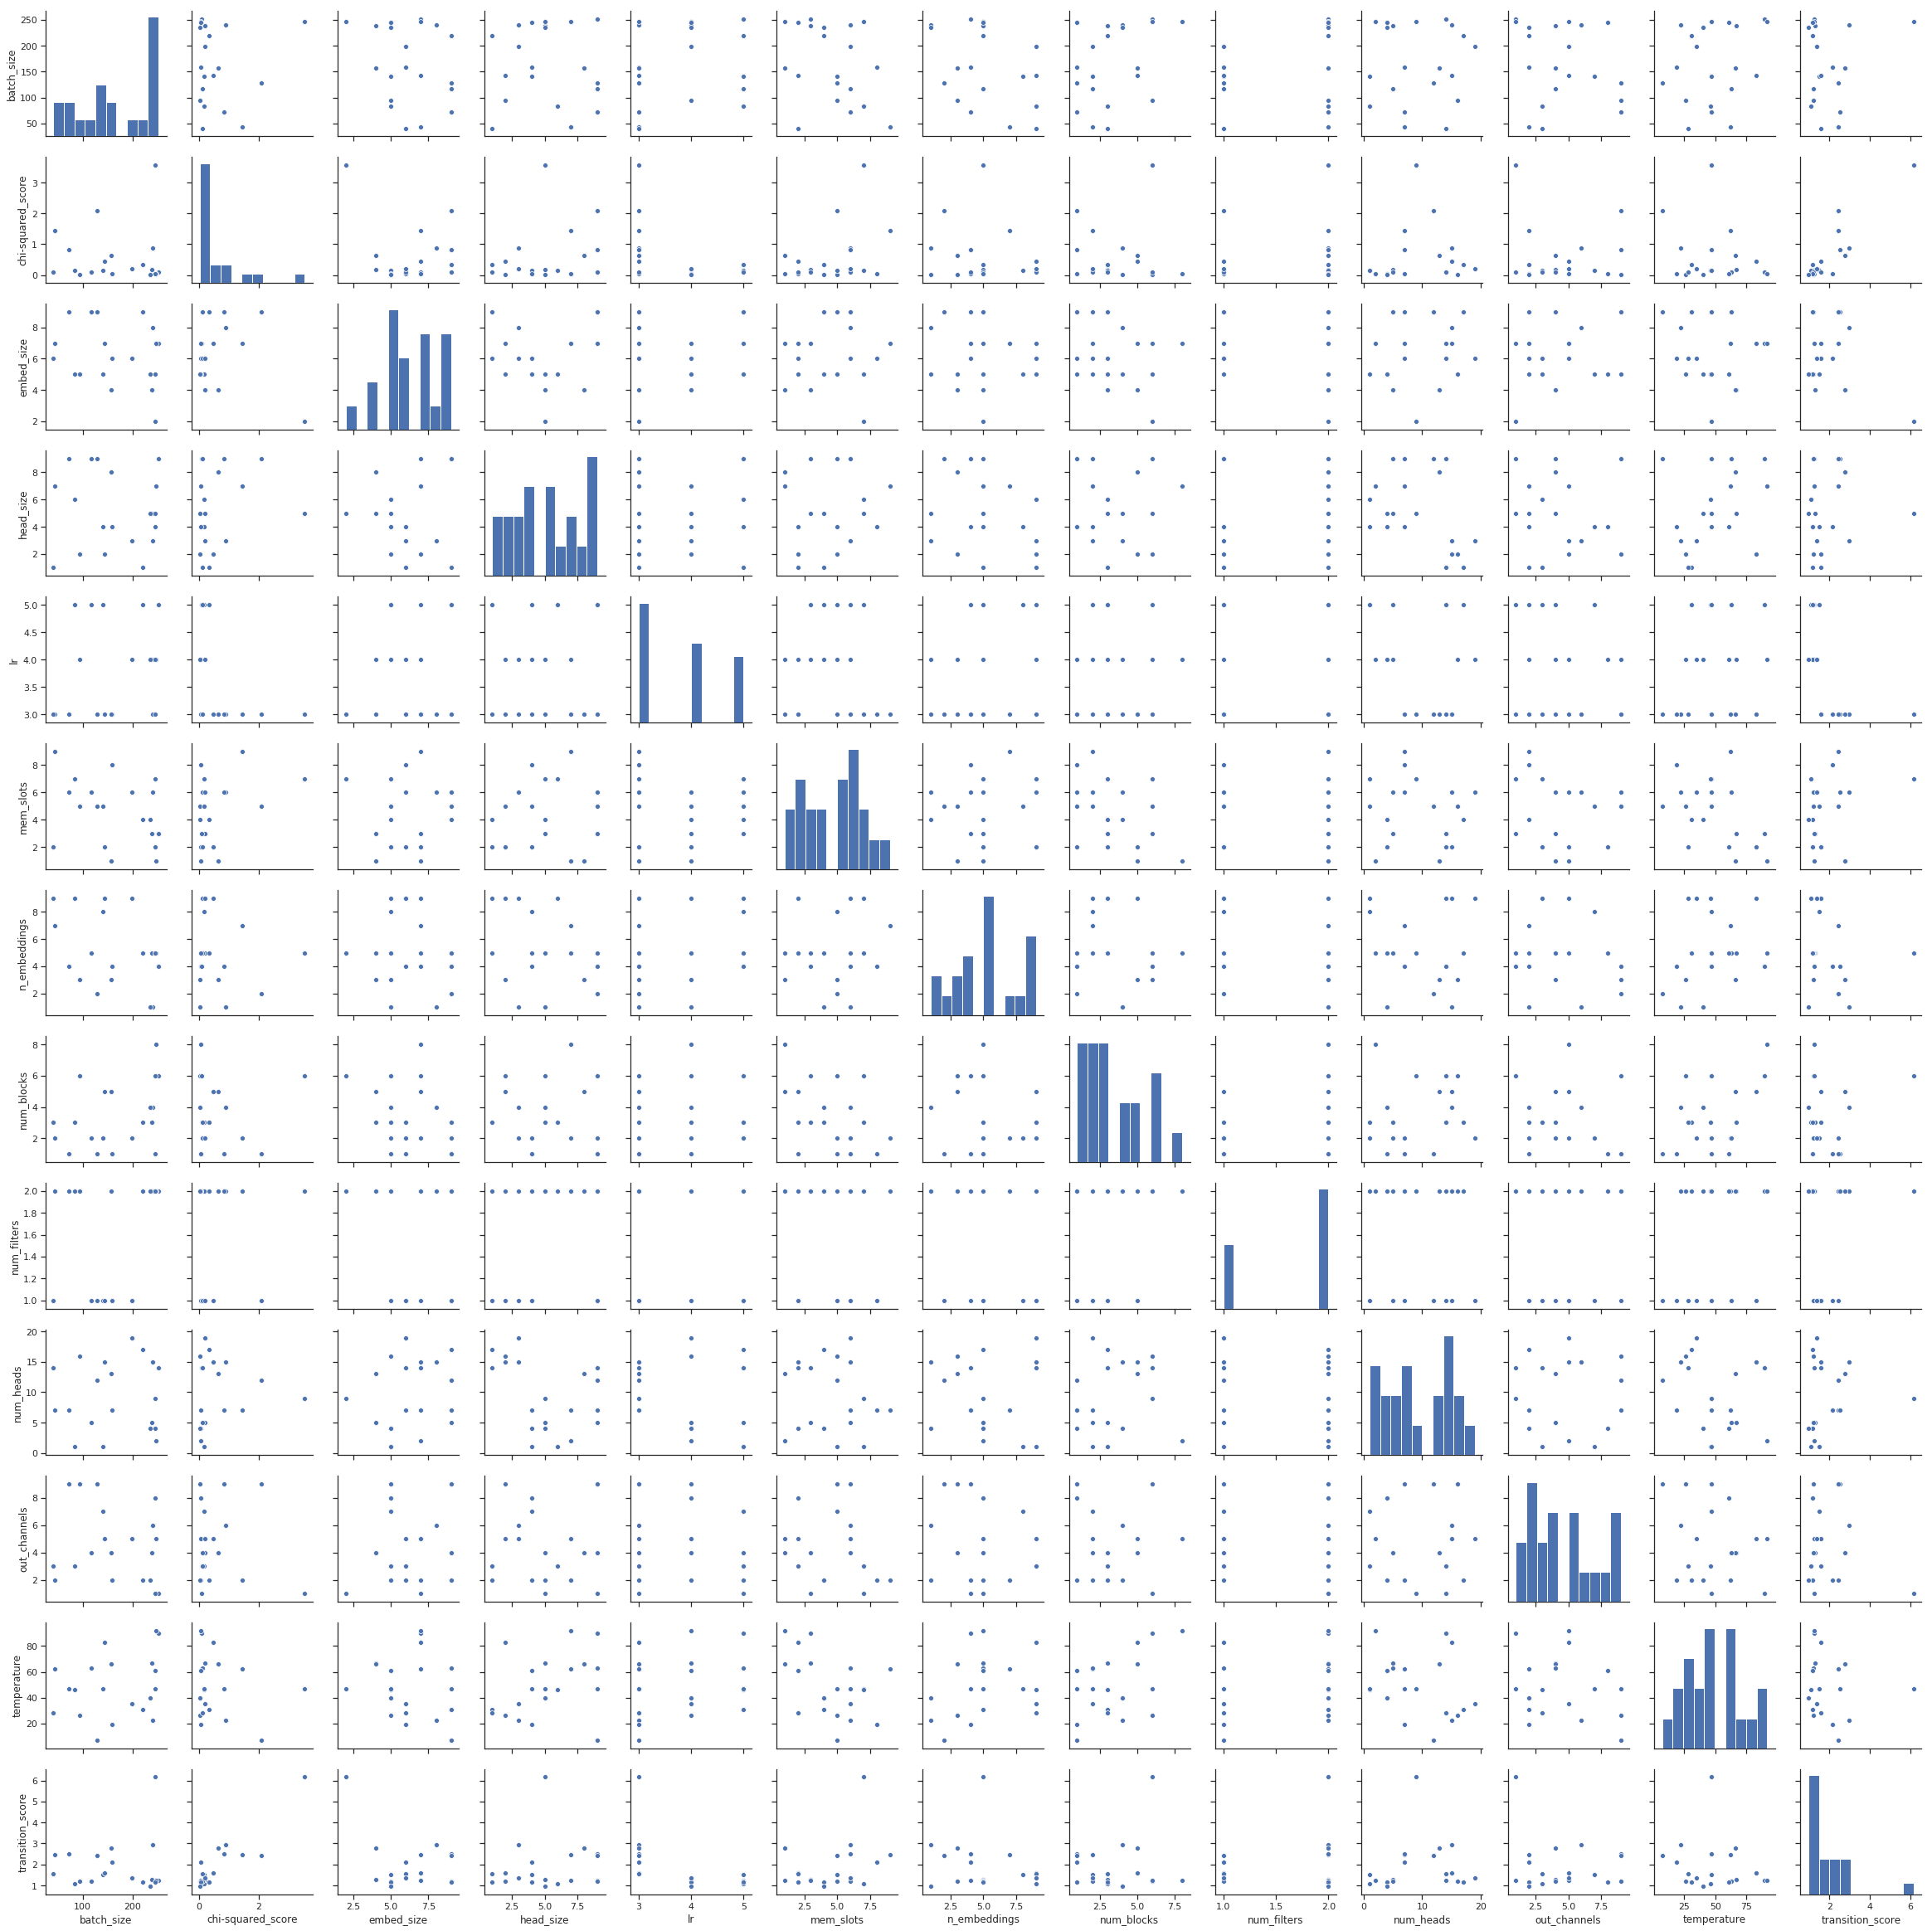

In [14]:
sns.set(style="ticks")

sns.pairplot(search_results)

Index(['batch_size', 'embed_size', 'head_size', 'lr', 'mem_slots',
       'n_embeddings', 'num_blocks', 'num_filters', 'num_heads',
       'out_channels', 'temperature'],
      dtype='object')
Intercept: 
 2.0181022797273407
Coefficients: 
 [ 6.36906213e-03 -1.32935906e-01  1.92957784e-01 -8.70195390e-01
  1.96082209e-01  1.54641292e-01  1.77030232e-01  1.97085262e-01
  1.76119006e-02 -2.32227869e-04 -1.66994469e-02]
batch_size      63.655
embed_size       1.575
head_size        2.280
lr               0.720
mem_slots        1.940
n_embeddings     2.010
num_blocks       1.680
num_filters      0.455
num_heads        5.085
out_channels     2.205
temperature     19.240
dtype: float64


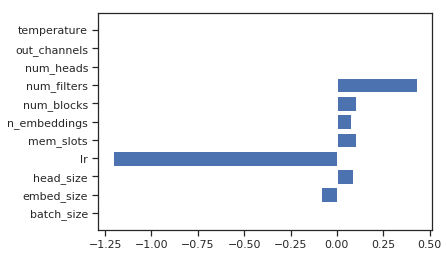

In [27]:
X = search_results.loc[:, ~search_results.columns.isin(['transition_score', 'chi-squared_score'])]
print(X.columns)
Y = search_results['transition_score']
 
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)
print(X.mad())

plt.barh(
    np.arange(len(regr.coef_)), 
    regr.coef_ / X.mad(), 
    tick_label=X.columns
)
plt.show()

In [30]:
# Helper function(s)

# round a number to n significant digits
def round_to_n(x, n = 2):
    return round(x, -int(floor(log10(abs(x)))) + (n - 1)) if x != 0 else 0

# Transform a date string into a datetime object
def str_to_datetime(string):
    return datetime.datetime.strptime(string, '%Y-%m-%d %H:%M:%S')

# TODO: more complex reduction: takes into account different ICD groups?
def reduce_icd(icd_full):
    return icd_full[:2]

def get_distribution(data, field, vocab_size, fake = True):
    counts = torch.zeros(vocab_size - 2)

    for i in range(2, vocab_size):
        if fake:
            counts[i - 2] = torch.sum(data == i)
        else:
            counts[i - 2] = field.vocab.freqs[field.vocab.itos[i]]

    freqs = counts / torch.sum(counts)
    
    return counts, freqs
    

In [142]:
%%time

filename = 'data/FINNGEN_ENDPOINTS_DF3_longitudinal_V1_for_SandBox.txt.gz'

endpoints = ['I9_HYPTENS', 'I9_ANGINA', 'I9_HEARTFAIL_NS', 'I9_STR_EXH', 'I9_CHD', 'C3_BREAST']

events = pd.read_csv(filename, compression = 'infer', sep='\t', nrows = 300_000_000)

print(events.columns)

# include all endpoints in a list
events = events[events['ENDPOINT'].isin(endpoints)]
#events = events.groupby('FINNGENID').filter(lambda x: len(x) > 1)
events = events[events['EVENT_YEAR'] >= 2000]

print(len(events))

filename = 'data/FINNGEN_MINIMUM_DATA_R3_V1.txt'

patients = pd.read_csv(filename, compression = 'infer', sep='\t')
events = pd.merge(events, patients[['FINNGENID', 'SEX']])
events.columns

print(len(events))

subjects = events['FINNGENID'].unique()
n_individuals = len(subjects)
print(n_individuals)
print(events['ENDPOINT'].unique())

Index(['FINNGENID', 'EVENT_AGE', 'EVENT_YEAR', 'ENDPOINT'], dtype='object')
533837
533837
42556
['I9_HEARTFAIL_NS' 'I9_ANGINA' 'I9_CHD' 'I9_HYPTENS' 'I9_STR_EXH'
 'C3_BREAST']
CPU times: user 1min 51s, sys: 8.86 s, total: 2min
Wall time: 2min


In [143]:
%%time

print(events.groupby('FINNGENID').apply(lambda x: x['EVENT_AGE'].max() - x['EVENT_AGE'].min()).describe())
print(events.groupby('FINNGENID').apply(lambda x: len(x)).describe())
#print(events.groupby('FINNGENID')['SEX'].first())
print(events.groupby('ENDPOINT')['FINNGENID'].count())

count    42556.000000
mean         5.494644
std          5.403814
min          0.000000
25%          0.270000
50%          4.030000
75%          9.640000
max         71.900000
dtype: float64
count    42556.000000
mean        12.544342
std         19.041123
min          1.000000
25%          3.000000
50%          5.000000
75%         14.000000
max        506.000000
dtype: float64
ENDPOINT
C3_BREAST            2521
I9_ANGINA           34688
I9_CHD              31640
I9_HEARTFAIL_NS    306792
I9_HYPTENS         133118
I9_STR_EXH          25078
Name: FINNGENID, dtype: int64
CPU times: user 10.7 s, sys: 12 ms, total: 10.7 s
Wall time: 10.7 s


In [144]:
def get_sequence_of_codes(subject):
    codes = ['None' for _ in range(2017 - 2000 + 1)]
    
    years = subject.groupby('EVENT_YEAR')
    
    for g, year in years:
        if year['ENDPOINT'].isin(['C3_BREAST']).any():
            value = 'C3_BREAST'
        elif year['ENDPOINT'].isin(['I9_CHD']).any():
            value = 'I9_CHD'
        else:
            value = np.random.choice(year['ENDPOINT'])
        codes[g - 2000] = value
        
    res = ' '.join(codes)
    return res

def get_age(subject):
    event = subject.sort_values('EVENT_AGE').iloc[0]
    
    age = event['EVENT_AGE'] + 2000 - event['EVENT_YEAR']
        
    return age


In [145]:
%%time

sequences_of_codes = events.groupby('FINNGENID').apply(get_sequence_of_codes)
#print(sequences_of_codes.head())
print(sequences_of_codes.apply(lambda x: len(x.split(' '))).describe())
print(sequences_of_codes.shape)

ages = events.groupby('FINNGENID').apply(get_age)
print(ages.shape)

sexes = events.groupby('FINNGENID')['SEX'].first()
sexes.shape

count    42556.0
mean        18.0
std          0.0
min         18.0
25%         18.0
50%         18.0
75%         18.0
max         18.0
dtype: float64
(42556,)
(42556,)
CPU times: user 3min 52s, sys: 140 ms, total: 3min 52s
Wall time: 3min 51s


(42556,)

In [146]:
#sequences = pd.DataFrame({'ENDPOINTS': sequences_of_codes.stack(), 'TIME_DIFFS': sequences_of_times.stack()})
sequences = pd.DataFrame({'ENDPOINT': sequences_of_codes, 'AGE': ages, 'SEX': sexes})
print(sequences.shape)
#sequences.head()


(42556, 3)


In [147]:
# https://stackoverflow.com/questions/52602071/dataframe-as-datasource-in-torchtext

class DataFrameDataset(Dataset):
    """Class for using pandas DataFrames as a datasource"""
    def __init__(self, examples, fields, filter_pred=None):
        """
        Create a dataset from a pandas dataframe of examples and Fields
        Arguments:
            examples pd.DataFrame: DataFrame of examples
            fields {str: Field}: The Fields to use in this tuple. The
                string is a field name, and the Field is the associated field.
            filter_pred (callable or None): use only exanples for which
                filter_pred(example) is true, or use all examples if None.
                Default is None
        """
        self.fields = dict(fields)
        self.examples = examples.apply(SeriesExample.fromSeries, args=(self.fields,), axis=1).tolist()
        if filter_pred is not None:
            self.examples = filter(filter_pred, self.examples)
        # Unpack field tuples
        for n, f in list(self.fields.items()):
            if isinstance(n, tuple):
                self.fields.update(zip(n, f))
                del self.fields[n]

class SeriesExample(Example):
    """Class to convert a pandas Series to an Example"""
    
    @classmethod
    def fromSeries(cls, data, fields):
        return cls.fromdict(data.to_dict(), fields)

    @classmethod
    def fromdict(cls, data, fields):
        ex = cls()
        for key, field in fields.items():
            if key not in data:
                raise ValueError("Specified key {} was not found in "
                "the input data".format(key))
            if field is not None:
                setattr(ex, key, field.preprocess(data[key]))
            else:
                setattr(ex, key, data[key])
        return ex

In [228]:
%%time

tokenize = lambda x: x.split(' ')

ENDPOINT = Field(tokenize = tokenize)
AGE = Field(sequential = False, use_vocab = False)
SEX = Field()

fields = [('ENDPOINT', ENDPOINT), ('AGE', AGE), ('SEX', SEX)]

train_sequences, val_sequences = train_test_split(sequences, test_size = 0.1)
print(train_sequences.shape, val_sequences.shape)

train = DataFrameDataset(train_sequences, fields)
val = DataFrameDataset(val_sequences, fields)
#print(val.examples[0].__dict__)

ENDPOINT.build_vocab(train, val)
SEX.build_vocab(train, val)

(38300, 3) (4256, 3)
CPU times: user 1.85 s, sys: 48 ms, total: 1.9 s
Wall time: 1.89 s


In [149]:
print(ENDPOINT.vocab.stoi['None'])
print(ENDPOINT.vocab.itos[2])
vocab_size = len(ENDPOINT.vocab.freqs) + 2
print(vocab_size)

print(ENDPOINT.vocab.freqs)

print(SEX.vocab.stoi['male'])
print(SEX.vocab.stoi['female'])
print(SEX.vocab.freqs)


2
None
9
Counter({'None': 609137, 'I9_HEARTFAIL_NS': 72729, 'I9_HYPTENS': 51510, 'I9_CHD': 16024, 'I9_ANGINA': 7910, 'I9_STR_EXH': 6873, 'C3_BREAST': 1825})
2
3
Counter({'male': 21661, 'female': 20895})


In [159]:
val_iter = Iterator(val, batch_size = len(val_sequences), repeat = True)

print(next(iter(val_iter)).ENDPOINT.transpose(0, 1).shape)
print(next(iter(val_iter)).AGE.shape)
print(next(iter(val_iter)).SEX.view(-1).shape)

torch.Size([4256, 18])
torch.Size([4256])
torch.Size([4256])


torch.Size([4256])


(array([   4.,   10.,   33.,  168.,  488., 1406., 1338.,  658.,  140.,
          11.]),
 array([-9. ,  1.6, 12.2, 22.8, 33.4, 44. , 54.6, 65.2, 75.8, 86.4, 97. ]),
 <a list of 10 Patch objects>)

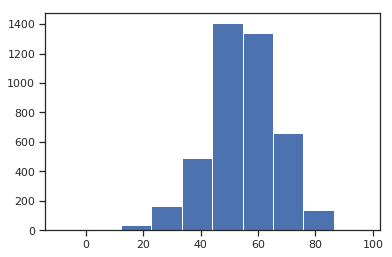

In [158]:
def get_age_distribution(dataset, dummy_batch_size = 128):
    res = []
    
    iterator = Iterator(dataset, batch_size = dummy_batch_size)
    
    for batch in iterator:
        res.append(batch.AGE)
        
    return torch.cat(res)
    
age_dist = get_age_distribution(val)
    
print(age_dist.shape)

plt.hist(age_dist.numpy())

In [227]:

def plot_data(data, ages, sexes, N=10, save=True):
    data = data[:N, :].numpy()
    
    new_data = np.empty(data.shape, dtype = 'object')
    for row, col in itertools.product(range(data.shape[0]), range(data.shape[1])):
        new_data[row, col] = ENDPOINT.vocab.itos[data[row, col]]
    
    cmap = {
        'None': '#ffffff',
    }
    
    fig, ax = plt.subplots(figsize=(8, 5))
    ax = catheat.heatmap(new_data, cmap = cmap, ax = ax, linewidths = .5, leg_pos = 'top')
    
    labels = list(map(lambda x: SEX.vocab.itos[sexes[x]] + ', ' + str(int(ages[x])), range(N)))
    plt.yticks(np.arange(N) + 0.5, labels, rotation = 0)
    
    if save:
        plt.savefig('figs/catheat.svg')
    else:
        plt.show()
            

    
batch = next(iter(val_iter))

data = batch.ENDPOINT.transpose(0, 1)
ages = batch.AGE
sexes = batch.SEX.view(-1)

N = 15

#plot_data(data, ages, sexes, N, False)


In [151]:
%%time

def get_transition_matrix(data, vocab_size = vocab_size, d = 1, eps = 1e-20):
    transition_count = torch.zeros(vocab_size - 1, vocab_size - 1)

    for indv in data:
        for idx in range(len(indv) - d):
            i1 = idx
            i2 = i1 + d
            ep1 = indv[i1]
            ep2 = indv[i2]
            if ep1 > 0 and ep2 > 0:
                transition_count[ep1 - 1, ep2 - 1] += 1
                    
    #print(torch.sum(transition_count, dim = 1))
    transition_freq = (transition_count.transpose(0, 1) / (torch.sum(transition_count, dim = 1) + eps)).transpose(0, 1)
                    
    return transition_count, transition_freq
        
iterator = Iterator(train, batch_size = len(train_sequences))

transition_count, transition_freq = get_transition_matrix(next(iter(iterator)).ENDPOINT.transpose(0, 1), vocab_size, d = 1)    
print(transition_count)
print(transition_freq)
print(transition_freq.sum(dim = 1))


tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 4.5906e+05, 1.4183e+04, 2.9787e+04, 8.9180e+03, 4.2690e+03,
         3.8260e+03, 1.3310e+03],
        [0.0000e+00, 1.0111e+04, 4.3360e+04, 2.6610e+03, 2.3400e+03, 3.8400e+02,
         4.4200e+02, 1.1700e+02],
        [0.0000e+00, 2.7361e+04, 3.2380e+03, 1.0740e+04, 6.8800e+02, 4.1900e+02,
         3.8900e+02, 8.7000e+01],
        [0.0000e+00, 8.3730e+03, 2.0680e+03, 6.8800e+02, 1.5540e+03, 5.0900e+02,
         1.2400e+02, 1.5000e+01],
        [0.0000e+00, 4.3610e+03, 5.9500e+02, 4.4400e+02, 3.1800e+02, 9.8500e+02,
         6.4000e+01, 4.0000e+00],
        [0.0000e+00, 3.4300e+03, 4.4700e+02, 4.2300e+02, 1.4300e+02, 5.0000e+01,
         1.1560e+03, 9.0000e+00],
        [0.0000e+00, 1.2530e+03, 1.8200e+02, 1.5800e+02, 1.8000e+01, 8.0000e+00,
         9.0000e+00, 3.0000e+00]])
tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00

In [13]:
%%time

iterator = Iterator(train, batch_size = len(train_sequences))

transition_count1, transition_freq1 = get_transition_matrix(next(iter(iterator)).ENDPOINT.transpose(0, 1), vocab_size, d = 1)    
transition_count2, transition_freq2 = get_transition_matrix(next(iter(val_iter)).ENDPOINT.transpose(0, 1), vocab_size, d = 1)    

print(transition_freq1)
print(transition_freq2)
print((transition_freq1 - transition_freq2).abs().mean())


tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1508, 0.6287, 0.1088, 0.0450, 0.0326, 0.0341],
        [0.0733, 0.0917, 0.7828, 0.0212, 0.0183, 0.0127],
        [0.0546, 0.1721, 0.0765, 0.4426, 0.2295, 0.0246],
        [0.1237, 0.0565, 0.1237, 0.2862, 0.3958, 0.0141],
        [0.1341, 0.2500, 0.0427, 0.0244, 0.0000, 0.5488]])
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1242, 0.6894, 0.0373, 0.0745, 0.0497, 0.0248],
        [0.0735, 0.0588, 0.8088, 0.0588, 0.0000, 0.0000],
        [0.0435, 0.1957, 0.1957, 0.3043, 0.2391, 0.0217],
        [0.1282, 0.1538, 0.0513, 0.2821, 0.3590, 0.0256],
        [0.1000, 0.2500, 0.0000, 0.1000, 0.0000, 0.5500]])
tensor(0.0285)
CPU times: user 252 ms, sys: 0 ns, total: 252 ms
Wall time: 252 ms


In [14]:
subjects = sequences.index
n_individuals = len(subjects)
print(n_individuals)
print(vocab_size / (n_individuals * sequence_length)) # The lower this is the easier it is for the generator to learn

922
0.0015184381778741865


In [15]:
# Test generator output

mem_slots = 4
head_size = 2
embed_size = 2
temperature = 1
num_heads = 2

G = RelationalMemoryGenerator(mem_slots, head_size, embed_size, vocab_size, temperature, num_heads)

start_token = torch.tensor([[2]])
memory = G.initial_state(batch_size = 1)

if cuda:
    G.cuda()
    memory = memory.cuda()
    start_token = start_token.cuda()

print(memory)
logits, tokens, _, memory = G(start_token, memory, sequence_length, None)
print(logits)
print(tokens)
print(memory)


tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]], device='cuda:0')
tensor([[[0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0.]]], device='cuda:0',
       grad_fn=<CatBackward>)
tensor([[2, 6, 2, 4, 4]], device='cuda:0')
tensor([[[ 1.7885, -0.6016, -0.8058, -0.1466],
         [ 1.1902,  1.1520, -0.5134, -0.0408],
         [ 0.9712, -0.9085, -0.0132, -0.5223],
         [ 1.5329, -0.7602, -0.9370,  1.0283]]], device='cuda:0',
       grad_fn=<AddBackward0>)


In [16]:
%%time

# Define generator evaluation functions

def chi_sqrd_dist(counts1, counts2, separate = False, eps = 1e-20):
    counts1 = counts1.view(1, -1)
    counts2 = counts2.view(1, -1)
    table = torch.cat([counts1, counts2], dim = 0)
    col_sums = torch.sum(table, dim = 0)
    row_sums = torch.sum(table, dim = 1)
    n = torch.sum(col_sums)
    
    table_freq = table / (n + eps)
    col_freqs = col_sums / (n + eps)
    row_freqs = row_sums / (n + eps)
    
    diffs = table_freq[0, :] / (row_freqs[0] + eps) - table_freq[1, :] / (row_freqs[1] + eps)
    diffs_sqrd = diffs ** 2
    diffs_sqrd_norm = diffs_sqrd / (col_freqs + eps)
    
    if separate: 
        return diffs_sqrd_norm
    
    chi_sqrd_distance = torch.sum(diffs_sqrd_norm)
    
    return chi_sqrd_distance

def get_fake_distribution(G, dataset, batch_size = 64, vocab_size = vocab_size, sequence_length = sequence_length):
    iterator = Iterator(dataset, batch_size = batch_size)
    
    if cuda:
        G.cuda()
    
    data_fake = []
    
    for batch in iterator:
        data_tmp = batch.ENDPOINT.transpose(0, 1)

        start_tokens = data_tmp[:, :1]
        memory = G.initial_state(batch_size = start_tokens.shape[0])

        if cuda:
            start_tokens = start_tokens.cuda()
            memory = memory.cuda()

        _, data_fake_tmp, _, _ = G(start_tokens, memory, sequence_length)
        
        data_fake.append(data_fake_tmp.cpu())
    
    data_fake = torch.cat(data_fake)
    
    counts_fake, freqs_fake = get_distribution(data_fake, None, vocab_size, fake = True)
    
    return counts_fake, freqs_fake
    
def get_score(G, ENDPOINT, dataset, batch_size = 64, vocab_size = vocab_size, sequence_length = sequence_length):
    counts_real, freqs_real = get_distribution(None, ENDPOINT, vocab_size, fake = False)
    
    counts_fake, freqs_fake = get_fake_distribution(G, dataset, batch_size, vocab_size, sequence_length)
    
    score = chi_sqrd_dist(counts_real, counts_fake)
    return score

def get_transition_score(G, dataset, batch_size = 64, d = 1, separate = False, vocab_size = vocab_size, sequence_length = sequence_length):
    iterator = Iterator(dataset, batch_size = batch_size)
    
    if cuda:
        G.cuda()
    
    data = []
    data_fake = []
    
    for batch in iterator:
        data_tmp = batch.ENDPOINT.transpose(0, 1)
        data.append(data_tmp)

        start_tokens = data_tmp[:, :1]
        memory = G.initial_state(batch_size = start_tokens.shape[0])

        if cuda:
            start_tokens = start_tokens.cuda()
            memory = memory.cuda()

        _, data_fake_tmp, _, _ = G(start_tokens, memory, sequence_length)
        
        data_fake.append(data_fake_tmp.cpu())
    
    
    data = torch.cat(data)
    data_fake = torch.cat(data_fake)
    
    transition_count_real, transition_freq_real = get_transition_matrix(data, vocab_size, d)
    transition_count_fake, transition_freq_fake = get_transition_matrix(data_fake, vocab_size, d)
    
    chi_sqrd_ds = []
    for i in range(vocab_size - 1):
        chi_sqrd_d = chi_sqrd_dist(transition_count_fake[i, :], transition_count_real[i, :])
        chi_sqrd_ds.append(chi_sqrd_d)
        
    chi_sqrd_ds = torch.tensor(chi_sqrd_ds)
    
    if separate:
        return chi_sqrd_ds
        
    return torch.mean(chi_sqrd_ds)
    
def get_aggregate_transition_score(G, dataset, batch_size = 64, separate1 = True, separate2 = True, vocab_size = vocab_size, sequence_length = sequence_length):
    scores = []
    for d in range(1, sequence_length):
        transition_score = get_transition_score(G, dataset, batch_size, d, separate1, vocab_size, sequence_length)
        scores.append(transition_score)
        
    result = torch.stack(scores)
    
    if separate2:
        return result
    
    if separate1:
        return torch.mean(result, dim = 0)
    else:
        return torch.mean(result)

val_data = next(iter(val_iter)).ENDPOINT.transpose(0, 1)

score = get_score(G, ENDPOINT, val)
print(score)

transition_score = get_transition_score(G, val, d = 1, separate = True)
print(transition_score)

aggr_transition_score = get_aggregate_transition_score(G, val, separate1 = True, separate2 = True)
print(aggr_transition_score)


tensor(0.5179)
tensor([3.6029, 1.0321, 2.7161, 1.2887, 0.2187, 1.1152])
tensor([[3.6115, 1.3615, 2.2156, 0.6018, 0.5024, 0.8596],
        [3.7124, 1.2639, 2.6439, 0.8005, 0.8858, 1.4557],
        [1.0000, 1.3892, 2.8696, 1.4999, 0.5591, 1.8254],
        [0.0000, 1.8861, 3.0378, 1.8555, 0.7489, 2.3080]])
CPU times: user 316 ms, sys: 8 ms, total: 324 ms
Wall time: 321 ms


In [17]:
# Test Discriminator output

n_embeddings = 2
embed_size = 2
out_channels = 5 
filter_sizes = [2, 3] # values can be at most the sequence_length

D = RelGANDiscriminator(n_embeddings, vocab_size, embed_size, sequence_length, out_channels, filter_sizes)

if cuda:
    D.cuda()

inp = logits
print(inp)
print(D(inp, False))
print(D(inp))


tensor([[[0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0.]]], device='cuda:0',
       grad_fn=<CatBackward>)
tensor([[0.5942, 0.5903]], device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([0.5922], device='cuda:0', grad_fn=<MeanBackward2>)


In [18]:
# Define the generator pre-train function

def pretrain_generator(G, train, batch_size, vocab_size, sequence_length, n_epochs, lr, print_step = 10):
    loss_function = nn.BCELoss()
    optimizer = torch.optim.Adam(G.parameters(), lr=lr)
    
    if cuda:
        G.cuda()
        loss_function.cuda()
    
    for e in range(n_epochs):
        train_iter = Iterator(train, batch_size = batch_size, device = device)
        loss_total = 0
        count = 0
        
        for batch in train_iter:
            train_data = batch.ENDPOINT.transpose(0, 1)
            train_data_one_hot = F.one_hot(train_data, vocab_size).type(Tensor)
            
            start_token = train_data[:, :1]
            optimizer.zero_grad()

            memory = G.initial_state(batch_size = train_data.shape[0])

            if cuda:
                start_token = start_token.cuda()
                memory = memory.cuda()
                
            logits, _, _, _ = G(start_token, memory, sequence_length, 1.0)

            loss = loss_function(logits, train_data_one_hot)
            
            loss_total += loss.item()
            count += 1

            loss.backward()
            optimizer.step()
            
        
        if e % print_step == 0:
            print(
                "[Epoch %d/%d] [G loss: %f]"
                % (e, n_epochs, loss_total / count)
            )

In [19]:
mem_slots = 4
head_size = 2
embed_size = 2
temperature = 1
num_heads = 2

G = RelationalMemoryGenerator(mem_slots, head_size, embed_size, vocab_size, temperature, num_heads)
    
score = get_score(G, ENDPOINT, val)
print(score)
aggr_transition_score = get_aggregate_transition_score(G, val, 64, True, True)
print(aggr_transition_score)
print(aggr_transition_score.mean())

batch_size = 64
pretrain_generator(G, train, batch_size, vocab_size, sequence_length, 2, 0.01, print_step = 1)

score = get_score(G, ENDPOINT, val)
print(score)
aggr_transition_score = get_aggregate_transition_score(G, val, 64, True, True)
print(aggr_transition_score)
print(aggr_transition_score.mean())

tensor(0.3332)
tensor([[3.1501, 0.4413, 2.4795, 0.8596, 0.3531, 1.3549],
        [1.5915, 0.5093, 2.7898, 0.6782, 0.1614, 1.4908],
        [1.0000, 0.5874, 1.9401, 0.3692, 0.3916, 1.9036],
        [0.0000, 0.4176, 1.6537, 0.7870, 0.9444, 1.3333]])
tensor(1.1328)
[Epoch 0/2] [G loss: 4.915725]
[Epoch 1/2] [G loss: 4.633242]
tensor(0.0546)
tensor([[1.5259, 0.6375, 1.6095, 0.6953, 0.8018, 2.0506],
        [1.9493, 0.7160, 0.6719, 1.3088, 1.3030, 1.5187],
        [1.0000, 0.7887, 0.9804, 1.3968, 0.6902, 0.2657],
        [0.0000, 0.4144, 0.8132, 0.1709, 0.7333, 1.5556]])
tensor(0.9832)


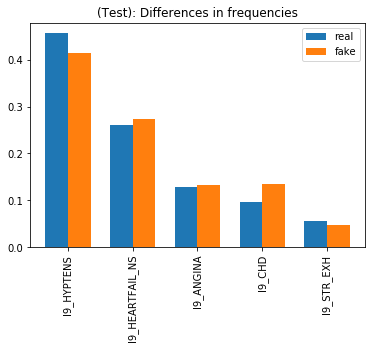

In [20]:
def save_grouped_barplot(freqs, freqs_fake, idx, title, N=10):
    freqs1 = freqs.numpy()[idx]
    freqs2 = freqs_fake.numpy()[idx]

    fig, ax = plt.subplots(figsize=(6,6))

    ind = np.arange(N)    # the x locations for the groups
    width = 0.35         # the width of the bars
    p1 = ax.bar(ind, freqs1, width, bottom=0)

    p2 = ax.bar(ind + width, freqs2, width, bottom=0)

    ax.set_title(title)
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(map(lambda x: ENDPOINT.vocab.itos[x], idx + 2), rotation=90)

    ax.legend((p1[0], p2[0]), ('real', 'fake'))
    ax.autoscale_view()
    
    fig.subplots_adjust(bottom=0.36)
    fig.savefig('figs/' + '_'.join(title.split(' ')).translate({ord(i): None for i in ':()'}) + '.svg')
    
def save_relative_and_absolute(freqs, freqs_fake, counts, counts_fake, vocab_size, prefix='', N_max=10):
    N = min(N_max, vocab_size - 2)
    if not prefix == '':
        prefix += ' '
    
    if N == vocab_size - 2:
        idx = np.arange(N)
        
        title = prefix + 'Differences in frequencies'
        save_grouped_barplot(freqs, freqs_fake, idx, title, N)
    else:
        abs_diffs = np.abs(freqs - freqs_fake)
        idx = np.argsort(abs_diffs)[-N:]
        idx = np.flip(idx)
        
        title = prefix + 'Largest absolute differences in frequencies'
        save_grouped_barplot(freqs, freqs_fake, idx, title, N)

        chi_sqrd_dists = chi_sqrd_dist(counts, counts_fake, separate = True)
        idx = np.argsort(chi_sqrd_dists)[-N:]
        idx = np.flip(idx)

        title = prefix + 'Largest relative differences in frequencies'
        save_grouped_barplot(freqs, freqs_fake, idx, title, N)
    
counts, freqs = get_distribution(None, ENDPOINT, vocab_size, fake = False)
counts_fake1, _ = get_fake_distribution(G, val)
counts_fake2, _ = get_fake_distribution(G, train)

counts_fake = counts_fake1 + counts_fake2
freqs_fake = counts_fake / torch.sum(counts_fake)

N_max = 10
prefix = '(Test):'

save_relative_and_absolute(freqs, freqs_fake, counts, counts_fake, vocab_size, prefix, N_max)

In [21]:
# Define the training function

def get_scores(G, ENDPOINT, dataset, batch_size = 128, separate1 = True, separate2 = True, \
               vocab_size = vocab_size, sequence_length = sequence_length):
    start_tokens = next(iter(iterator)).ENDPOINT.transpose(0, 1)[:, :1]
    
    score1 = get_score(G, ENDPOINT, dataset, batch_size, vocab_size, sequence_length)
    
    score2 = get_aggregate_transition_score(G, dataset, batch_size, separate1, separate2, vocab_size, sequence_length)
    
    return score1, score2.mean(), score2

def train_GAN(G, D, train, val_iter, batch_size, vocab_size, sequence_length, \
              n_epochs, lr, temperature, print_step = 10, score_fn = get_scores):    
    scores = []
    accuracies_real = []
    accuracies_fake = []
    
    score = score_fn(G, ENDPOINT, val)
    print('Scores before training:', *score)
    scores.append(score)
    
    print('pretraining generator...')
    pretrain_generator(G, train, batch_size, vocab_size, sequence_length, max(n_epochs // 10, 1), \
                       lr * 100, print_step = max(n_epochs // 10 - 1, 1))
    print('pretraining complete')
    
    score = score_fn(G, ENDPOINT, val)
    print("[Scores:", *score, "]")
    scores.append(score)
    
    adversarial_loss = torch.nn.BCELoss()
    
    optimizer_G = torch.optim.Adam(G.parameters(), lr=lr)
    optimizer_D = torch.optim.Adam(D.parameters(), lr=lr)
    
    if cuda:
        G.cuda()
        D.cuda()
        adversarial_loss.cuda()
    
    for e in range(n_epochs):
        train_iter = Iterator(train, batch_size = batch_size, device = device)
        #loss_total = 0
        #count = 0
        
        for batch in train_iter:
            train_data = batch.ENDPOINT.transpose(0, 1)
            train_data_one_hot = F.one_hot(train_data, vocab_size).type(Tensor)

            start_token = train_data[:, :1]
            
            # Adversarial ground truths
            valid = Variable(Tensor(train_data.shape[0]).fill_(1.0), requires_grad=False)
            fake = Variable(Tensor(train_data.shape[0]).fill_(0.0), requires_grad=False)

            optimizer_G.zero_grad()

            # Generate a batch of images
            memory = G.initial_state(batch_size = train_data.shape[0])
            if cuda:
                memory = memory.cuda()

            temp = temperature ** ((e + 1) / n_epochs)
            fake_one_hot, _, _, _ = G(start_token, memory, sequence_length, temp)

            # Loss measures generator's ability to fool the discriminator
            g_loss = adversarial_loss(D(fake_one_hot).view(-1), valid)

            g_loss.backward()
            optimizer_G.step()

            optimizer_D.zero_grad()

            # Measure discriminator's ability to classify real from generated samples
            D_out_real = D(train_data_one_hot).view(-1)
            D_out_fake = D(fake_one_hot.detach()).view(-1)
            
            #print(D_out_real)
            #print(torch.round(D_out_real))
            accuracy_real = torch.mean(D_out_real)
            accuracy_fake = torch.mean(1 - D_out_fake)
            
            real_loss = adversarial_loss(D_out_real, valid)
            fake_loss = adversarial_loss(D_out_fake, fake)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

        if e % print_step == 0:
            print()
            print(
                "[Epoch %d/%d] [D loss: %f] [G loss: %f] [Acc real: %f] [Acc fake: %f]"
                % (e, n_epochs, d_loss.item(), g_loss.item(), accuracy_real, accuracy_fake)
            )
            score = score_fn(G, ENDPOINT, val)
            print("[Scores:", *score, "]")
            scores.append(score)
            accuracies_real.append(accuracy_real)
            accuracies_fake.append(accuracy_fake)
            
    score = score_fn(G, ENDPOINT, val)
    print('Scores after training:', *score)
    scores.append(score)
            
    output = [[] for _ in range(len(scores[0]))]
    for i in range(len(scores)):
        for j in range(len(scores[i])):
            output[j].append(scores[i][j])

    output.append(accuracies_real)
    output.append(accuracies_fake)
            
    for j in range(len(output)):
        output[j] = torch.stack(output[j])
            
    return tuple(output)


Scores before training: tensor(0.2726) tensor(1.1840) tensor([[3.0244, 0.8414, 1.6349, 0.4987, 0.1370, 1.2153],
        [3.7533, 0.9779, 1.7311, 0.2570, 0.3719, 2.2427],
        [1.0000, 0.8103, 2.5675, 0.4588, 0.2826, 1.6522],
        [0.0000, 0.8973, 1.4231, 1.5975, 0.4178, 0.6222]])
pretraining generator...
[Epoch 0/1] [G loss: 5.155181]
pretraining complete
[Scores: tensor(0.0715) tensor(0.9057) tensor([[2.0225, 0.6427, 2.0135, 1.0919, 0.6902, 1.6986],
        [1.8838, 0.6349, 1.0855, 0.9809, 0.5119, 2.1260],
        [1.0000, 0.5005, 0.9091, 0.2051, 0.3949, 0.7101],
        [0.0000, 0.3728, 0.4381, 0.2611, 0.8127, 0.7500]]) ]

[Epoch 0/10] [D loss: 0.693741] [G loss: 0.715832] [Acc real: 0.488462] [Acc fake: 0.511211]
[Scores: tensor(0.0272) tensor(1.1094) tensor([[2.3070, 0.7637, 1.1841, 0.7107, 0.6555, 2.6219],
        [2.1533, 0.4617, 1.0755, 0.5078, 0.8488, 2.1984],
        [1.0000, 0.4847, 1.9431, 0.7494, 1.4773, 1.8519],
        [0.0000, 0.3159, 0.7136, 0.1235, 1.1562, 1.3220

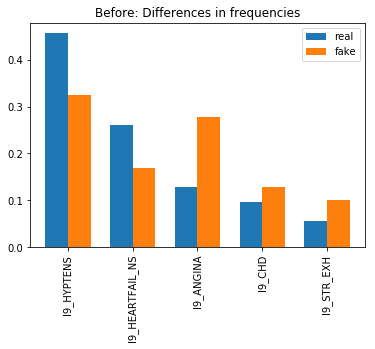

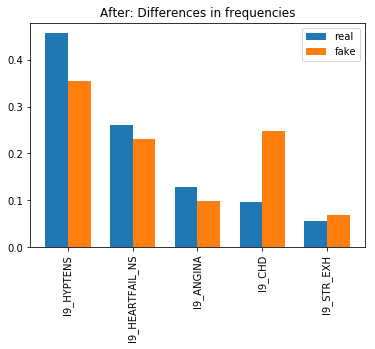

In [24]:
# Train the GAN

start_time = time.time()

# Generator params
mem_slots = 1
head_size = 6
embed_size = 10
temperature = 5
num_heads = 10
num_blocks = 6

G = RelationalMemoryGenerator(mem_slots, head_size, embed_size, vocab_size, temperature, num_heads, num_blocks)

# Discriminator params
n_embeddings = 5
embed_size = embed_size
out_channels = 15
filter_sizes = [2, 3, 4] # values can be at most the sequence_length

D = RelGANDiscriminator(n_embeddings, vocab_size, embed_size, sequence_length, out_channels, filter_sizes)

counts_fake1, _ = get_fake_distribution(G, val)
counts_fake2, _ = get_fake_distribution(G, train)

counts_fake = counts_fake1 + counts_fake2
freqs_fake = counts_fake / torch.sum(counts_fake)

N_max = 10
prefix = 'Before:'

save_relative_and_absolute(freqs, freqs_fake, counts, counts_fake, vocab_size, prefix, N_max)



batch_size = 64
n_epochs = 10
print_step = max(n_epochs // 10, 1)
lr = 1e-4

# Train the GAN
scores1, scores2, scores3, accuracies_real, accuracies_fake = train_GAN(
    G, D, train, val_iter, batch_size, vocab_size, sequence_length, n_epochs, lr, temperature, print_step
)



counts_fake1, _ = get_fake_distribution(G, val)
counts_fake2, _ = get_fake_distribution(G, train)

counts_fake = counts_fake1 + counts_fake2
freqs_fake = counts_fake / torch.sum(counts_fake)

prefix = 'After:'

save_relative_and_absolute(freqs, freqs_fake, counts, counts_fake, vocab_size, prefix, N_max)

print('Time taken:', round_to_n(time.time() - start_time, n = 3), 'seconds')


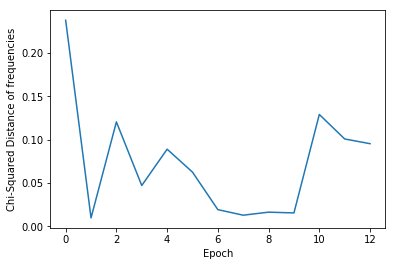

In [30]:
%matplotlib inline

plt.plot(range(scores1.shape[0]), scores1.numpy())
plt.ylabel('Chi-Squared Distance of frequencies')
plt.xlabel('Epoch')
plt.savefig('figs/chisqrd_freqs.svg')

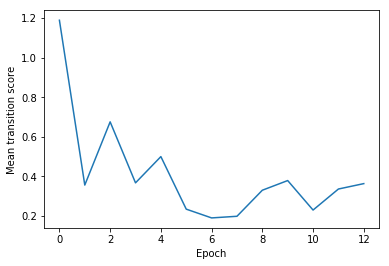

In [31]:
plt.plot(range(scores2.shape[0]), scores2.numpy())
plt.ylabel('Mean transition score')
plt.xlabel('Epoch')
plt.savefig('figs/mean_transition_score.svg')

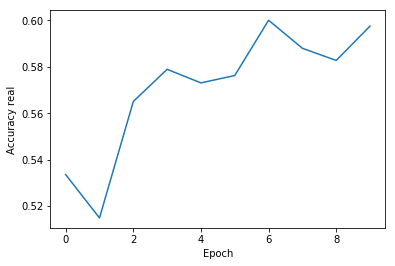

In [32]:
plt.plot(range(accuracies_real.shape[0]), accuracies_real.detach().cpu().numpy())
plt.ylabel('Accuracy real')
plt.xlabel('Epoch')
plt.savefig('figs/accuracy_real.svg')

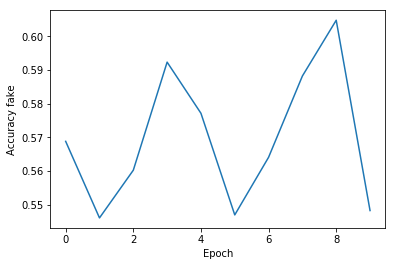

In [33]:
plt.plot(range(accuracies_fake.shape[0]), accuracies_fake.detach().cpu().numpy())
plt.ylabel('Accuracy fake')
plt.xlabel('Epoch')
plt.savefig('figs/accuracy_fake.svg')

In [34]:
for d in range(1, sequence_length):
    plt.plot(range(scores3.shape[0]), scores3[:, d - 1, :].numpy())
    plt.ylabel('Transition score')
    plt.xlabel('Epoch')
    title = 'd=' + str(d)
    plt.title(title)
    labels = [ENDPOINT.vocab.itos[i] for i in range(1, vocab_size)]
    plt.legend(labels)
    plt.savefig('figs/' + title + '.svg')
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [35]:
for v in range(1, vocab_size):
    plt.plot(range(scores3.shape[0]), scores3[:, :, v - 1].numpy())
    plt.ylabel('Transition score')
    plt.xlabel('Epoch')
    title = 'enpoint=' + ENDPOINT.vocab.itos[v]
    plt.title(title)
    labels = ['d=' + str(i) for i in range(1, sequence_length)]
    plt.legend(labels)
    plt.savefig('figs/' + title + '.svg')
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [36]:
test_size = 10
start_tokens = torch.randint(2, vocab_size, (test_size, 1))
print(start_tokens)

memory = G.initial_state(batch_size = test_size)

if cuda:
    memory = memory.cuda()
    start_tokens = start_tokens.cuda()
    
_, data_fake, _, _ = G(start_tokens, memory, sequence_length)

data_fake

tensor([[4],
        [4],
        [3],
        [3],
        [4],
        [6],
        [5],
        [3],
        [2],
        [3]])


tensor([[4, 4, 5, 5, 3],
        [4, 4, 4, 4, 4],
        [3, 3, 3, 3, 3],
        [3, 3, 3, 3, 3],
        [4, 2, 1, 1, 1],
        [6, 6, 6, 6, 6],
        [5, 5, 3, 3, 3],
        [3, 3, 3, 3, 3],
        [2, 2, 2, 2, 3],
        [3, 3, 3, 3, 3]], device='cuda:0')